# Exploring Joint-Fusion Process for OSIC Pulmonary Fibrosis Progression dataset
This method is inspired from the study/work:
- Deep learning for predicting COVID-19 malignant progression, https://doi.org/10.1016/j.media.2021.102096

Where the authors applied a ResNet architecture and MLP for imaging and clinical data feature extraction respectively. They then fused the feature vectors by concatenation and fed them into an LSTM network followed by a fully connected network to product an output.

For our project, we will use an LSTM encoder for our patient tabular data, since they are recorded via time-series. While a simpler ResNet3D CNN will be used to encode our patient CT-scan (only baseline). Afterwards, the outputs from the previous 2 models will be concatenated and fed into a RNN fusion model to train based on the tabular time-series feature.

In [13]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import sys
import pandas as pd
import random
import pickle
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

random.seed(3244)

# Image Data Preparation
- Current image preprocessing script returns each patient's scan data in the shape: 
    - *(D_i,1,256,256)*
    - where Depth, D_i = Number of scan slices unique to each patient
    - and Channel = 1 (Greyscale for our raw data)
- To feed image data into ResNet3D CNN, data is required to be in shape:
    - *(1,D,256,256)*
    - with D being standardised across every patient, hence padding/resampling is needed.

Also, patient(s) with invalid CT-scan (D=0) will be dropped from the data.

In [ ]:
# Assign repo root path
repo_root = Path(os.getcwd()).resolve().parent
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))
    print(f"Added to sys.path: {repo_root}")

Added to sys.path: D:\Keven(Work)\cs3244


In [16]:
# Process dicom ct-scans into npy files
from preprocessing.image_preprocessing import preprocess_scans

data_dir_absolute = repo_root / "data"
if not os.path.exists(f'{data_dir_absolute}/preprocessed_scans.pkl'):
    preprocessed_scans = preprocess_scans(data_dir_absolute)
    pickle.dump(preprocessed_scans, open(f'{data_dir_absolute}/preprocessed_scans.pkl', 'wb'))

# load scan data in if already preprocessed before
preprocessed_scans = pickle.load(open(f'{data_dir_absolute}/preprocessed_scans.pkl', 'rb'))

In [3]:
# function to prepare preprocessed scans into standard volumes for 3D ResNet/CNN encoder
def build_image_volumes(preprocessed_scans):
    scan_data = {}
    for patientID, volume in preprocessed_scans.items():
        dimensions = volume.shape
        if dimensions[0] == 0:  # exclude patient scans with 0 depth
            continue
        else:
            # change from (D,1,256,256) -> (1,D,256,256)
            volume = volume.transpose(1, 0, 2, 3)
            volume = resample_depth_with_padding(volume)
            scan_data[patientID] = volume
    return scan_data


# helper: resample to fixed depth per scan volume
def resample_depth_with_padding(volume, target_d=128):
    # from volume: (1, D, H, W) -> (1, target_d, H, W)
    C, D, H, W = volume.shape
    if D >= target_d:
        # downsample evenly
        indices = np.linspace(0, D-1, target_d).astype(int)
        return volume[:, indices, :, :]
    else:
        # pad before and after along depth axis
        pad_before = (target_d - D) // 2
        pad_after = target_d - D - pad_before
        padded = np.pad(volume, ((0,0),(pad_before,pad_after),(0,0),(0,0)), mode='constant', constant_values=0)
        return padded


new_scans = build_image_volumes(preprocessed_scans)

# Tabular Data Preparation
Imported tabular data already has scaled continuous variables to account for time-series, now we just need to encode categorical variables and reformat it into shape: *(time_steps, features)* so it can be fed into LSTM encoder

In [17]:
# directly import tabular data from script
from preprocessing.tabular_preprocessing import train_df, val_df

print(train_df)

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker   
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker   
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker   

   Weeks_scaled  FVC_scaled  Baseline_FVC  
0     -1.510341   -0.448119     -0.448119  
1     -1.122587   -0.566423     -0.448119  
2     -1.036419   -0.745635     -0.448119  
3     -0.950252   -0.648415     -0.448119  
4     -0.864084   -0.736264     -0.448119  
                     Patient  Weeks   FVC     Percent  Age     Sex  \
0  ID00020637202178344345685     18  2297  117.770714   66  Female   
1  ID00020637202178344345685     19  2145  109.977441   66  Female   
2  ID00020637202178344345685     21  22

In [5]:
# function to prepare tabular data for LSTM encoder
def prepare_tabular_dataset(dataframe):
    # encode Sex
    dataframe["Sex_is_male"] = (dataframe["Sex"] == "Male").astype(int)
    # one-hot encode smoking status
    smoking_dummies = pd.get_dummies(dataframe["SmokingStatus"], prefix="smoke")
    # join smoking status df back to original df
    dataframe = pd.concat([dataframe, smoking_dummies], axis=1)
    # choose X features
    feature_cols = [
        "Weeks_scaled",
        "Percent",
        "Age",
        "Sex_is_male",
        "smoke_Never smoked",
        "smoke_Ex-smoker",
        "smoke_Currently smokes",
        "Baseline_FVC"
    ]
    # this is Y target
    target_col = "FVC_scaled"

    # group data by patient ID
    patient_features = {}
    for pid, df in dataframe.groupby("Patient"):
        df = df.sort_values("Weeks")   # ensure time-series order
        
        features = df[feature_cols].values.astype(np.float32)  # shape = (T, F)
        targets = df[target_col].values.astype(np.float32)     # shape = (T,)
        # store structured patient data
        patient_features[pid] = {
            "features": features,
            "targets": targets,
            "times": df["Weeks_scaled"].values.astype(np.float32)
        }
    return patient_features


X_tabular_train = prepare_tabular_dataset(train_df)
X_tabular_val = prepare_tabular_dataset(val_df)

In [122]:
# preview tabular data, each patient should have input shape: (time points, features=8)
early_stop = 0
for patientID, patientfeatures in X_tabular_train.items():
    if early_stop == 5:
        break
    else:
        feature_shapes = {
            "features": patientfeatures['features'].shape,
            "targets": patientfeatures['targets'].shape,
            "times": patientfeatures['times'].shape
        }
        print(f"{patientID}: {feature_shapes}")
        early_stop += 1

ID00173637202238329754031: {'features': (9, 8), 'targets': (9,), 'times': (9,)}
ID00123637202217151272140: {'features': (9, 8), 'targets': (9,), 'times': (9,)}
ID00213637202257692916109: {'features': (9, 8), 'targets': (9,), 'times': (9,)}
ID00421637202311550012437: {'features': (10, 8), 'targets': (10,), 'times': (10,)}
ID00417637202310901214011: {'features': (9, 8), 'targets': (9,), 'times': (9,)}


# Final Data Preparation
Split image data into train-validation set based on already-split tabular data. For patients with invalid CT-scan dropped earlier, they are excluded from final tabular data too (only 1). As patients have different number of time-stamps for their tabular data, padding is also done to ensure all have same time steps.

Create custom dataset class to load both Image and Tabular data as batches of tensors.

In [7]:
# 1. Extract patient IDs from tabular train/val sets
train_patient_ids = set(train_df["Patient"].unique())
val_patient_ids   = set(val_df["Patient"].unique())

# 2. Remove patients whose images are removed due to 0 slices/depth
valid_ids = set(new_scans.keys())   # built image volumes

train_patient_ids = train_patient_ids & valid_ids
val_patient_ids   = val_patient_ids & valid_ids

# 3. Build image splits
X_image_train = {pid: new_scans[pid] for pid in train_patient_ids}
X_image_val   = {pid: new_scans[pid] for pid in val_patient_ids}

# 4. Ensure tabular splits
X_tabular_train = {pid: X_tabular_train[pid] for pid in train_patient_ids}
X_tabular_val = {pid: X_tabular_val[pid] for pid in val_patient_ids}

# 4. Preview
print("Train patients with images:", len(X_image_train))
print("Val patients with images:", len(X_image_val))
print("Train patients with tabular:", len(X_tabular_train))
print("Val patients with images:", len(X_tabular_val))


Train patients with images: 139
Val patients with images: 36
Train patients with tabular: 139
Val patients with images: 36


In [8]:
# custom Dataset class for Joint-level-fusion model
class JointFusion_Dataset(Dataset):
    def __init__(self, patient_ids, tabular_dict, image_dict):
            self.patient_ids = sorted(patient_ids)
            self.tabular_dict = tabular_dict
            self.image_dict = image_dict

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        pid = self.patient_ids[idx]

        # for tabular data
        tab = self.tabular_dict[pid]["features"]      # shape (T, F=8)
        target = self.tabular_dict[pid]["targets"]     # shape (T,)    
        # convert to tensor
        tab = torch.tensor(tab, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)

        # for image data (same for all timesteps, since we only have base CT-scan)
        img = self.image_dict[pid]       # numpy array (1, 64, 256, 256)
        img = torch.tensor(img, dtype=torch.float32)

        return {
            "patient_id": pid,
            "tabular": tab,
            "image": img,
            "target": target,
            "seq_len": tab.size(0)
        }

# custom collate function to pad tabular time series into equal sizes 
def collate_fn(batch):
    tabs = [item["tabular"] for item in batch]
    imgs = torch.stack([item["image"] for item in batch])  # images already fixed size
    targets = [item["target"] for item in batch]
    seq_lens = torch.tensor([len(t) for t in tabs], dtype=torch.long)

    # Pad tabular sequences and targets
    tabs_padded = pad_sequence(tabs, batch_first=True, padding_value=0.0)       # (B, T_max, F)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=0.0) # (B, T_max)

    # Create mask for loss calculation: 1 for real timesteps, 0 for padded
    mask = torch.zeros_like(targets_padded, dtype=torch.float32)
    for i, l in enumerate(seq_lens):
        mask[i, :l] = 1.0

    return {
        "tabular": tabs_padded,
        "image": imgs,
        "target": targets_padded,
        "seq_len": seq_lens,
        "mask": mask
    }


In [9]:
# build dataloaders
train_dataset = JointFusion_Dataset(
    patient_ids=train_patient_ids,
    tabular_dict=X_tabular_train,
    image_dict=X_image_train
)
val_dataset = JointFusion_Dataset(
    patient_ids=val_patient_ids,
    tabular_dict=X_tabular_val,
    image_dict=X_image_val
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Joint-Fusion Models
1. Process image and tabular data in parallel using different models:
    - Image data --> [ResNet3D encoder] --> Image encodings
    - Tabular data --> [LSTM encoder] --> Tabular encodings
2. (Image encodings + Tabular encodings) --> [Fusion RNN] --> output predictions


In [ ]:
# ---------------------------------
# 1. LSTM encoder for tabular data
# ---------------------------------
class LSTMEncoder(nn.Module):
    def __init__(self, in_dim=8, hidden_dim=64, num_layers=1, out_dim=64):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=in_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        # x: (B, T, in_dim)
        out, _ = self.lstm(x)       # out: (B, T, hidden_dim)
        out = self.fc(out)          # (B, T, out_dim)
        return out


# -------------------------------------------
# 2. ResNet3D encoder for image data
# -------------------------------------------
# 3D basic residual block for ResNet3D
class BasicBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)

        # projection if channel count or stride changes
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

# Actual ResNet3D encoder
class ResNet3DEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = BasicBlock3D(1, 16, stride=2)   # output: 16×32×128×128
        self.layer2 = BasicBlock3D(16, 32, stride=2)  # output: 32×16×64×64
        self.layer3 = BasicBlock3D(32, 64, stride=2)  # output: 64×8×32×32
        self.layer4 = BasicBlock3D(64, 128, stride=2) # output: 128×4×16×16

        self.pool = nn.AdaptiveAvgPool3d(1)  # -> 128×1×1×1
        self.fc = nn.Linear(128, 64)         # Final embedding

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)    # (B, 128)
        x = self.fc(x)               # (B, 64)
        return x

# --------------------------------------------------------
# 3. Fusion RNN Model that concatenates output 
#    from previous two model to be trained on
# --------------------------------------------------------
class FusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.tabular_encoder = LSTMEncoder(
            in_dim=8,          # tabular features per time step
            hidden_dim=64,
            num_layers=1,
            out_dim=64,
        )  
        self.image_encoder = ResNet3DEncoder()  # unchanged (B,64)

        # Fusion head
        self.fusion = nn.Sequential(
            nn.Linear(64 + 64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, tabular, image):
        tab_feat = self.tabular_encoder(tabular)  # (B, T, 64)
        img_feat = self.image_encoder(image)      # (B, 64)

        # Broadcast image features across T
        img_feat_exp = img_feat.unsqueeze(1).expand(-1, tab_feat.size(1), -1)  # (B, T, 64)
        fused = torch.cat([tab_feat, img_feat_exp], dim=2)  # (B, T, 128)
        out = self.fusion(fused).squeeze(-1)               # (B, T)
        return out


# Training and Validation Loop
skip executing this section if model already trained

In [14]:
# training function
def train_model(train_loader, val_loader, num_epochs=20, lr=1e-4):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = FusionModel().to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss(reduction='none')

    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        # ---- TRAIN ----
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            tab = batch["tabular"].to(device)       # (B, T_max, F)
            img = batch["image"].to(device)         # (B, 1, D, H, W)
            target = batch["target"].to(device)     # (B, T_max)
            seq_len = batch["seq_len"].to(device)   # (B,)

            optimizer.zero_grad()
            # Forward pass: output shape (B, T_max)
            pred = model(tab, img)  
            # Mask padded timesteps
            mask = torch.arange(target.size(1), device=device)[None, :] < seq_len[:, None]  # (B, T_max)
            loss = (loss_fn(pred, target) * mask).sum() / mask.sum()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * tab.size(0)

        train_loss /= len(train_loader.dataset)

        # ---- VALIDATION ----
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                tab = batch["tabular"].to(device)
                img = batch["image"].to(device)
                target = batch["target"].to(device)
                seq_len = batch["seq_len"].to(device)

                pred = model(tab, img)
                mask = torch.arange(target.size(1), device=device)[None, :] < seq_len[:, None]
                loss = (loss_fn(pred, target) * mask).sum() / mask.sum()
                val_loss += loss.item() * tab.size(0)

        val_loss /= len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        # ---- SAVE BEST MODEL ----
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_jointFusion_model.pth")
            print("... Saved new best model")

    print(f"\nTraining complete. Best validation loss: {best_val_loss:.4f}")
    return model


In [111]:
# Run the training
model = train_model(train_loader, val_loader, num_epochs=20, lr=1e-4)

Epoch 1/20 | Train Loss: 0.9462 | Val Loss: 0.6855
... Saved new best model
Epoch 2/20 | Train Loss: 0.8544 | Val Loss: 0.6385
... Saved new best model
Epoch 3/20 | Train Loss: 0.8041 | Val Loss: 0.5916
... Saved new best model
Epoch 4/20 | Train Loss: 0.7058 | Val Loss: 0.5614
... Saved new best model
Epoch 5/20 | Train Loss: 0.6337 | Val Loss: 0.4912
... Saved new best model
Epoch 6/20 | Train Loss: 0.5503 | Val Loss: 0.5408
Epoch 7/20 | Train Loss: 0.4826 | Val Loss: 0.4976
Epoch 8/20 | Train Loss: 0.4424 | Val Loss: 0.5426
Epoch 9/20 | Train Loss: 0.3949 | Val Loss: 0.5548
Epoch 10/20 | Train Loss: 0.4033 | Val Loss: 0.5238
Epoch 11/20 | Train Loss: 0.3590 | Val Loss: 0.5232
Epoch 12/20 | Train Loss: 0.3487 | Val Loss: 0.5454
Epoch 13/20 | Train Loss: 0.3524 | Val Loss: 0.5198
Epoch 14/20 | Train Loss: 0.3075 | Val Loss: 0.5874
Epoch 15/20 | Train Loss: 0.3256 | Val Loss: 0.5116
Epoch 16/20 | Train Loss: 0.2698 | Val Loss: 0.4620
... Saved new best model
Epoch 17/20 | Train Loss: 0

# Evaluation 

In [112]:
# Load the model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = FusionModel().to(DEVICE)
model.load_state_dict(torch.load("best_jointFusion_model.pth"))
print(f"Loaded 'best_jointFusion_model' on device: {DEVICE}")

Loaded 'best_jointFusion_model' on device: cuda


In [113]:
# function for evaluations
def evaluate_model(model, val_loader, device=None):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for batch in val_loader:
            tab = batch["tabular"].to(device)
            img = batch["image"].to(device)
            target = batch["target"].to(device)
            seq_len = batch["seq_len"].to(device)
            # Forward pass
            pred = model(tab, img)  # (B, T_max)
            # Mask padded timesteps
            mask = torch.arange(target.size(1), device=device)[None, :] < seq_len[:, None]
            # Only keep valid timesteps
            for i in range(pred.size(0)):
                y_pred_list.append(pred[i, :seq_len[i]].cpu().numpy())
                y_true_list.append(target[i, :seq_len[i]].cpu().numpy())

    return y_pred_list, y_true_list

y_pred_list, y_true_list = evaluate_model(model, val_loader)


In [ ]:
# flatten all timesteps into 1D arrays for RMSE/MAE
y_pred_flat = np.concatenate(y_pred_list)
y_true_flat = np.concatenate(y_true_list)

rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
mae = mean_absolute_error(y_true_flat, y_pred_flat)
r2 = r2_score(y_true_flat, y_pred_flat)
print(f"Validation RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

Validation RMSE: 0.6241, MAE: 0.5161, R2: 0.4855


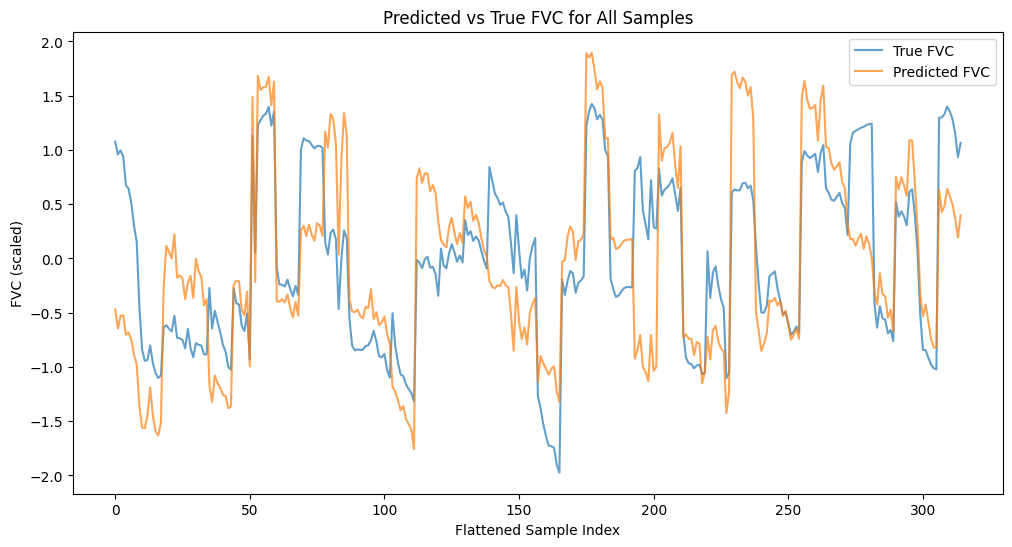

In [115]:
# plot across all patients (not very interpretable)
def plot_fvc_flat(y_true_list, y_pred_list, figsize=(12, 6)):
    """
    Plot predicted vs true FVC for the entire dataset (flattened).

    Args:
        y_true_list: list of tensors, each shape (T,)
        y_pred_list: list of tensors, each shape (T,)
    """
    # Convert lists of tensors into one long tensor
    if isinstance(y_true_list[0], torch.Tensor):
        y_true = torch.cat(y_true_list).cpu().numpy()
        y_pred = torch.cat(y_pred_list).cpu().numpy()
    else:
        y_true = np.concatenate(y_true_list)
        y_pred = np.concatenate(y_pred_list)

    plt.figure(figsize=figsize)
    plt.plot(y_true, label="True FVC", alpha=0.7)
    plt.plot(y_pred, label="Predicted FVC", alpha=0.7)
    
    plt.xlabel("Flattened Sample Index")
    plt.ylabel("FVC (scaled)")
    plt.title("Predicted vs True FVC for All Samples")
    plt.legend()
    plt.show()

plot_fvc_flat(y_pred_list, y_true_list)


In [116]:
# create a dict object for each val patient and their respective pred + true values
patient_plots = {}
counter = 0
for id, item in X_tabular_val.items():
    prev = counter
    duration = len(item['times'])
    weeks_scaled = item['times']
    counter += duration
    curr_patient_pred = y_pred_flat[prev: counter]
    curr_patient_true = y_true_flat[prev: counter]
    patient_plots[id] = {"weeks_scaled": weeks_scaled, "y_pred": curr_patient_pred, "y_true": curr_patient_true}

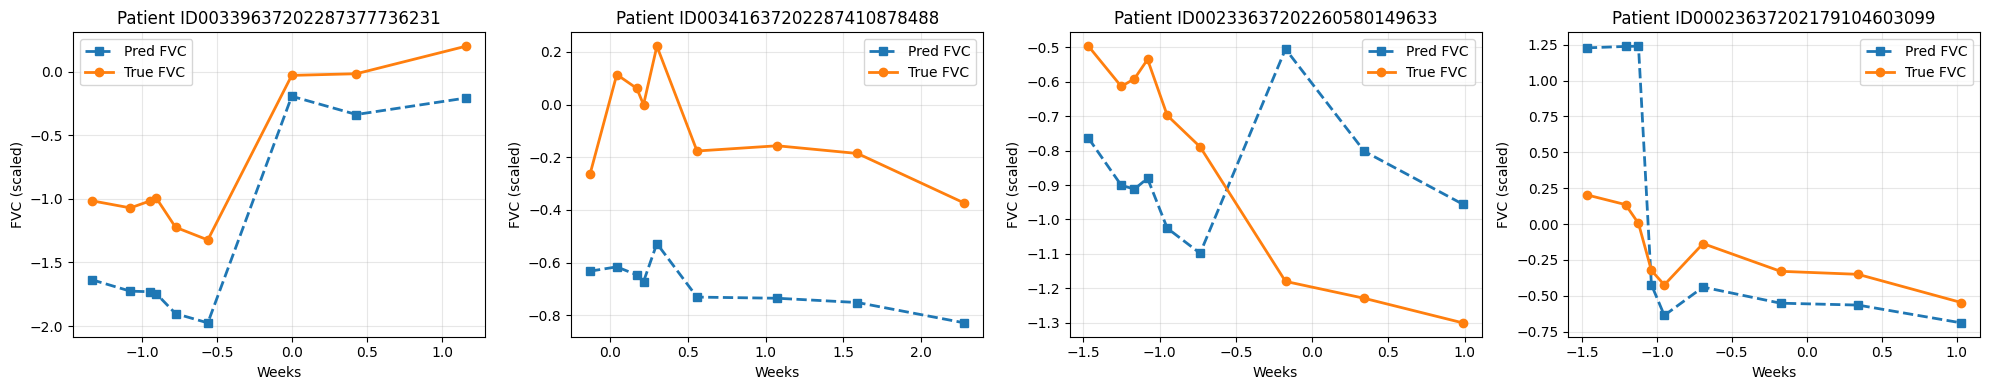

In [119]:
# randomly sample 4 out of the 36 validation patients and plot their results
random_patients = random.sample(list(patient_plots.items()), 4)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

for i, patient_results in enumerate(random_patients):
    patient = patient_results[0]
    weeks = patient_results[1]['weeks_scaled']
    y_pred = patient_results[1]['y_pred']
    y_true = patient_results[1]['y_true']
    axes[i].plot(weeks, y_pred, 's--', label='Pred FVC', linewidth=2, markersize=6)
    axes[i].plot(weeks, y_true, 'o-', label='True FVC', linewidth=2, markersize=6)
    axes[i].set_xlabel('Weeks')
    axes[i].set_ylabel('FVC (scaled)')
    axes[i].set_title(f'Patient {patient}')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()